<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_4_S6_coverage.ipynb"><< Determining Poseidon-4 coverage</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_S6_waveforms.ipynb">Poseidon-4 waveforms >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn Sentinel-6: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **<a href="1_1_S6_data_access_SFTP.ipynb" target="_blank">1_1_S6_data_access_SFTP</a>**; this will download the required Poseidon-4 products for this notebook.

</div>
<hr>

# 1.3 Sentinel-6 tracks

### Data used

| Product Description  | Data Store collection ID| Product Navigator | 
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-6 Poseidon-4 Altimetry level-2 High Resolution (NTC) | EO:EUM:DAT:0128 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0128?query=Altimetry%20NTC&filter=satellite__Sentinel-6&results=20&s=advanced" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* Objective

### Outline

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Investigating Poseidon-4 tracks](#section1)
 1. [Plotting Poseidon-4 level-2 range data](#section2)
 1. [Checking Poseidon-4 level-2 flags](#section3)
 1. [Plotting Poseidon-4 level-2 geophysical variables](#section4)

<hr>

In [1]:
# library imports
import cartopy
import cmocean
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import warnings
import glob

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Reading Poseidon-4 level-2 data
[Back to top](#TOC_TOP)

</div>

In [2]:
# selecting SAFE directories
SAFE_product = glob.glob(os.path.join(os.getcwd(), 'products','S6A_P4_2__HR*_NT_*','*STD*.nc'))[0]

In [3]:
# read data
ds_01 = xr.open_dataset(SAFE_product, group="data_01")
ds_01_ku = xr.open_dataset(SAFE_product, group="data_01/ku")
ds_20_ku = xr.open_dataset(SAFE_product, group="data_20/ku")
ds_01.close()
ds_01_ku.close()
ds_20_ku.close()

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Plotting Poseidon-4 level-2 range data
[Back to top](#TOC_TOP)

</div>

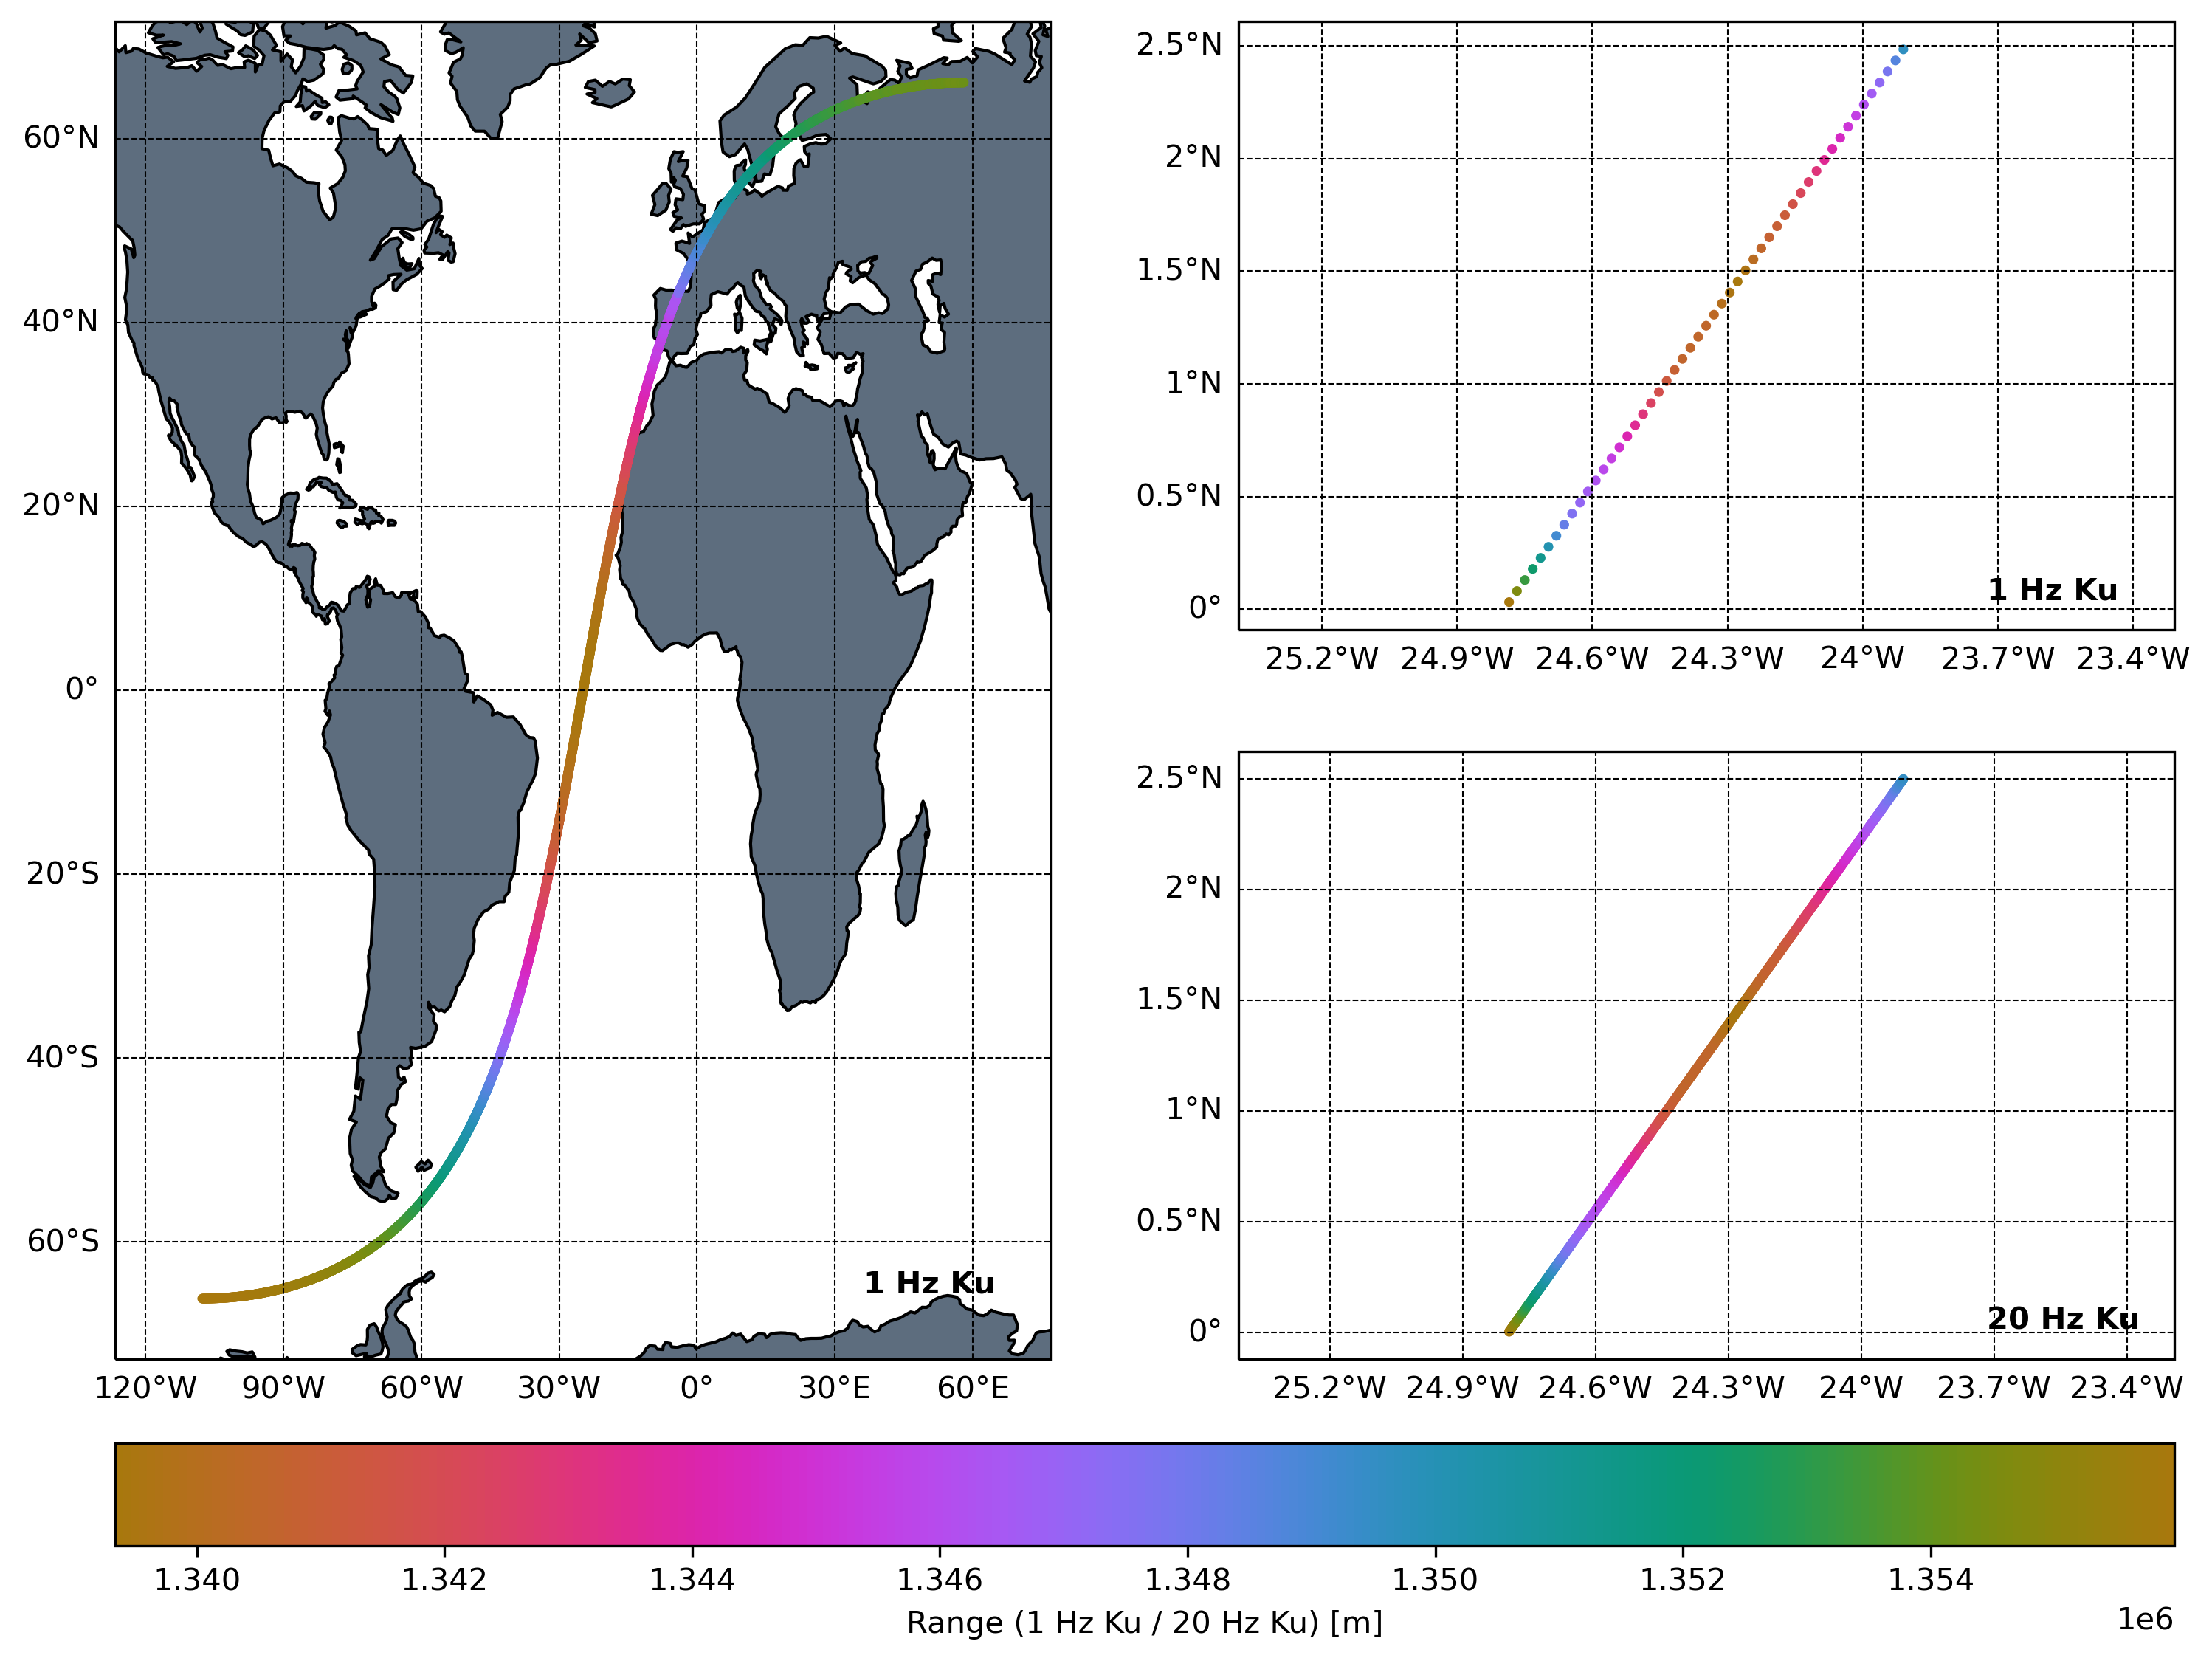

In [4]:
fig = plt.figure(figsize=(12, 10), dpi=300)
axs = [plt.subplot(121, projection=cartopy.crs.PlateCarree()),
       plt.subplot(222, projection=cartopy.crs.PlateCarree()),
       plt.subplot(224, projection=cartopy.crs.PlateCarree())]

lon_vars = [ds_01.longitude, ds_01.longitude, ds_20_ku.longitude]
lat_vars = [ds_01.latitude, ds_01.latitude, ds_20_ku.latitude]
plot_vars = [ds_01_ku.range_ocean, ds_01_ku.range_ocean, ds_20_ku.range_ocean]

for m, lon, lat, plot_var, annot in zip(axs, lon_vars, lat_vars, plot_vars, ['1 Hz Ku', '1 Hz Ku', '20 Hz Ku']):
    if m == axs[0]:
        f1 = m.scatter(lon, lat, c=plot_var, cmap=cmocean.cm.phase, 
                       s=10, marker='o', edgecolors=None, linewidth=0.0, zorder=1)
    else:
        ii = np.where((lat>0) & (lat<2.5))
        f2 = m.scatter(lon[ii], lat[ii], c=plot_var[ii], cmap=cmocean.cm.phase, 
                       s=10, marker='o', edgecolors=None, linewidth=0.0, zorder=1)
    
    m.annotate(annot, (0.8, 0.05), xycoords='axes fraction', color='k', fontweight='bold')

    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    if m == axs[0]:
        m.set_aspect(2)
        m.set_adjustable('datalim')
    else:
        m.set_aspect(0.5)
        m.set_adjustable('datalim')        

cbar = plt.colorbar(f1, ax=axs, orientation="horizontal", pad=0.05)
cbar.set_label('Range (1 Hz Ku / 20 Hz Ku) [m]')
plt.savefig('1_4_S6_tracks.png')
plt.show()

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Checking Poseidon-4 level-2 flags
[Back to top](#TOC_TOP)

</div>

In [5]:
# get the relevant flags
flags_range = np.array(ds_01_ku.range_ocean_qual).astype(float)
flags_range[flags_range != 0.0] = 1.1
flags_range[flags_range == 0.0] = np.nan

flags_swh = np.array(ds_01_ku.swh_ocean_qual).astype(float)
flags_swh[flags_swh != 0.0] = 1.15
flags_swh[flags_swh == 0.0] = np.nan

flags_ws = np.array(ds_01_ku.sig0_ocean_qual).astype(float)
flags_ws[flags_ws != 0.0] = 1.2
flags_ws[flags_ws == 0.0] = np.nan

flags_ssha = np.array(ds_01_ku.range_ocean_qual).astype(float) \
           + np.array(ds_01.surface_classification_flag).astype(float) \
           + np.array(ds_01.rad_surface_type_flag).astype(float)
flags_ssha[flags_ssha != 0.0] = 1.25
flags_ssha[flags_ssha == 0.0] = np.nan

In [6]:
# normalise the range to help with plotting
norm_range = ds_01_ku.range_ocean
norm_range = (norm_range - np.nanmin(norm_range)) / (np.nanmax(norm_range) - np.nanmin(norm_range))

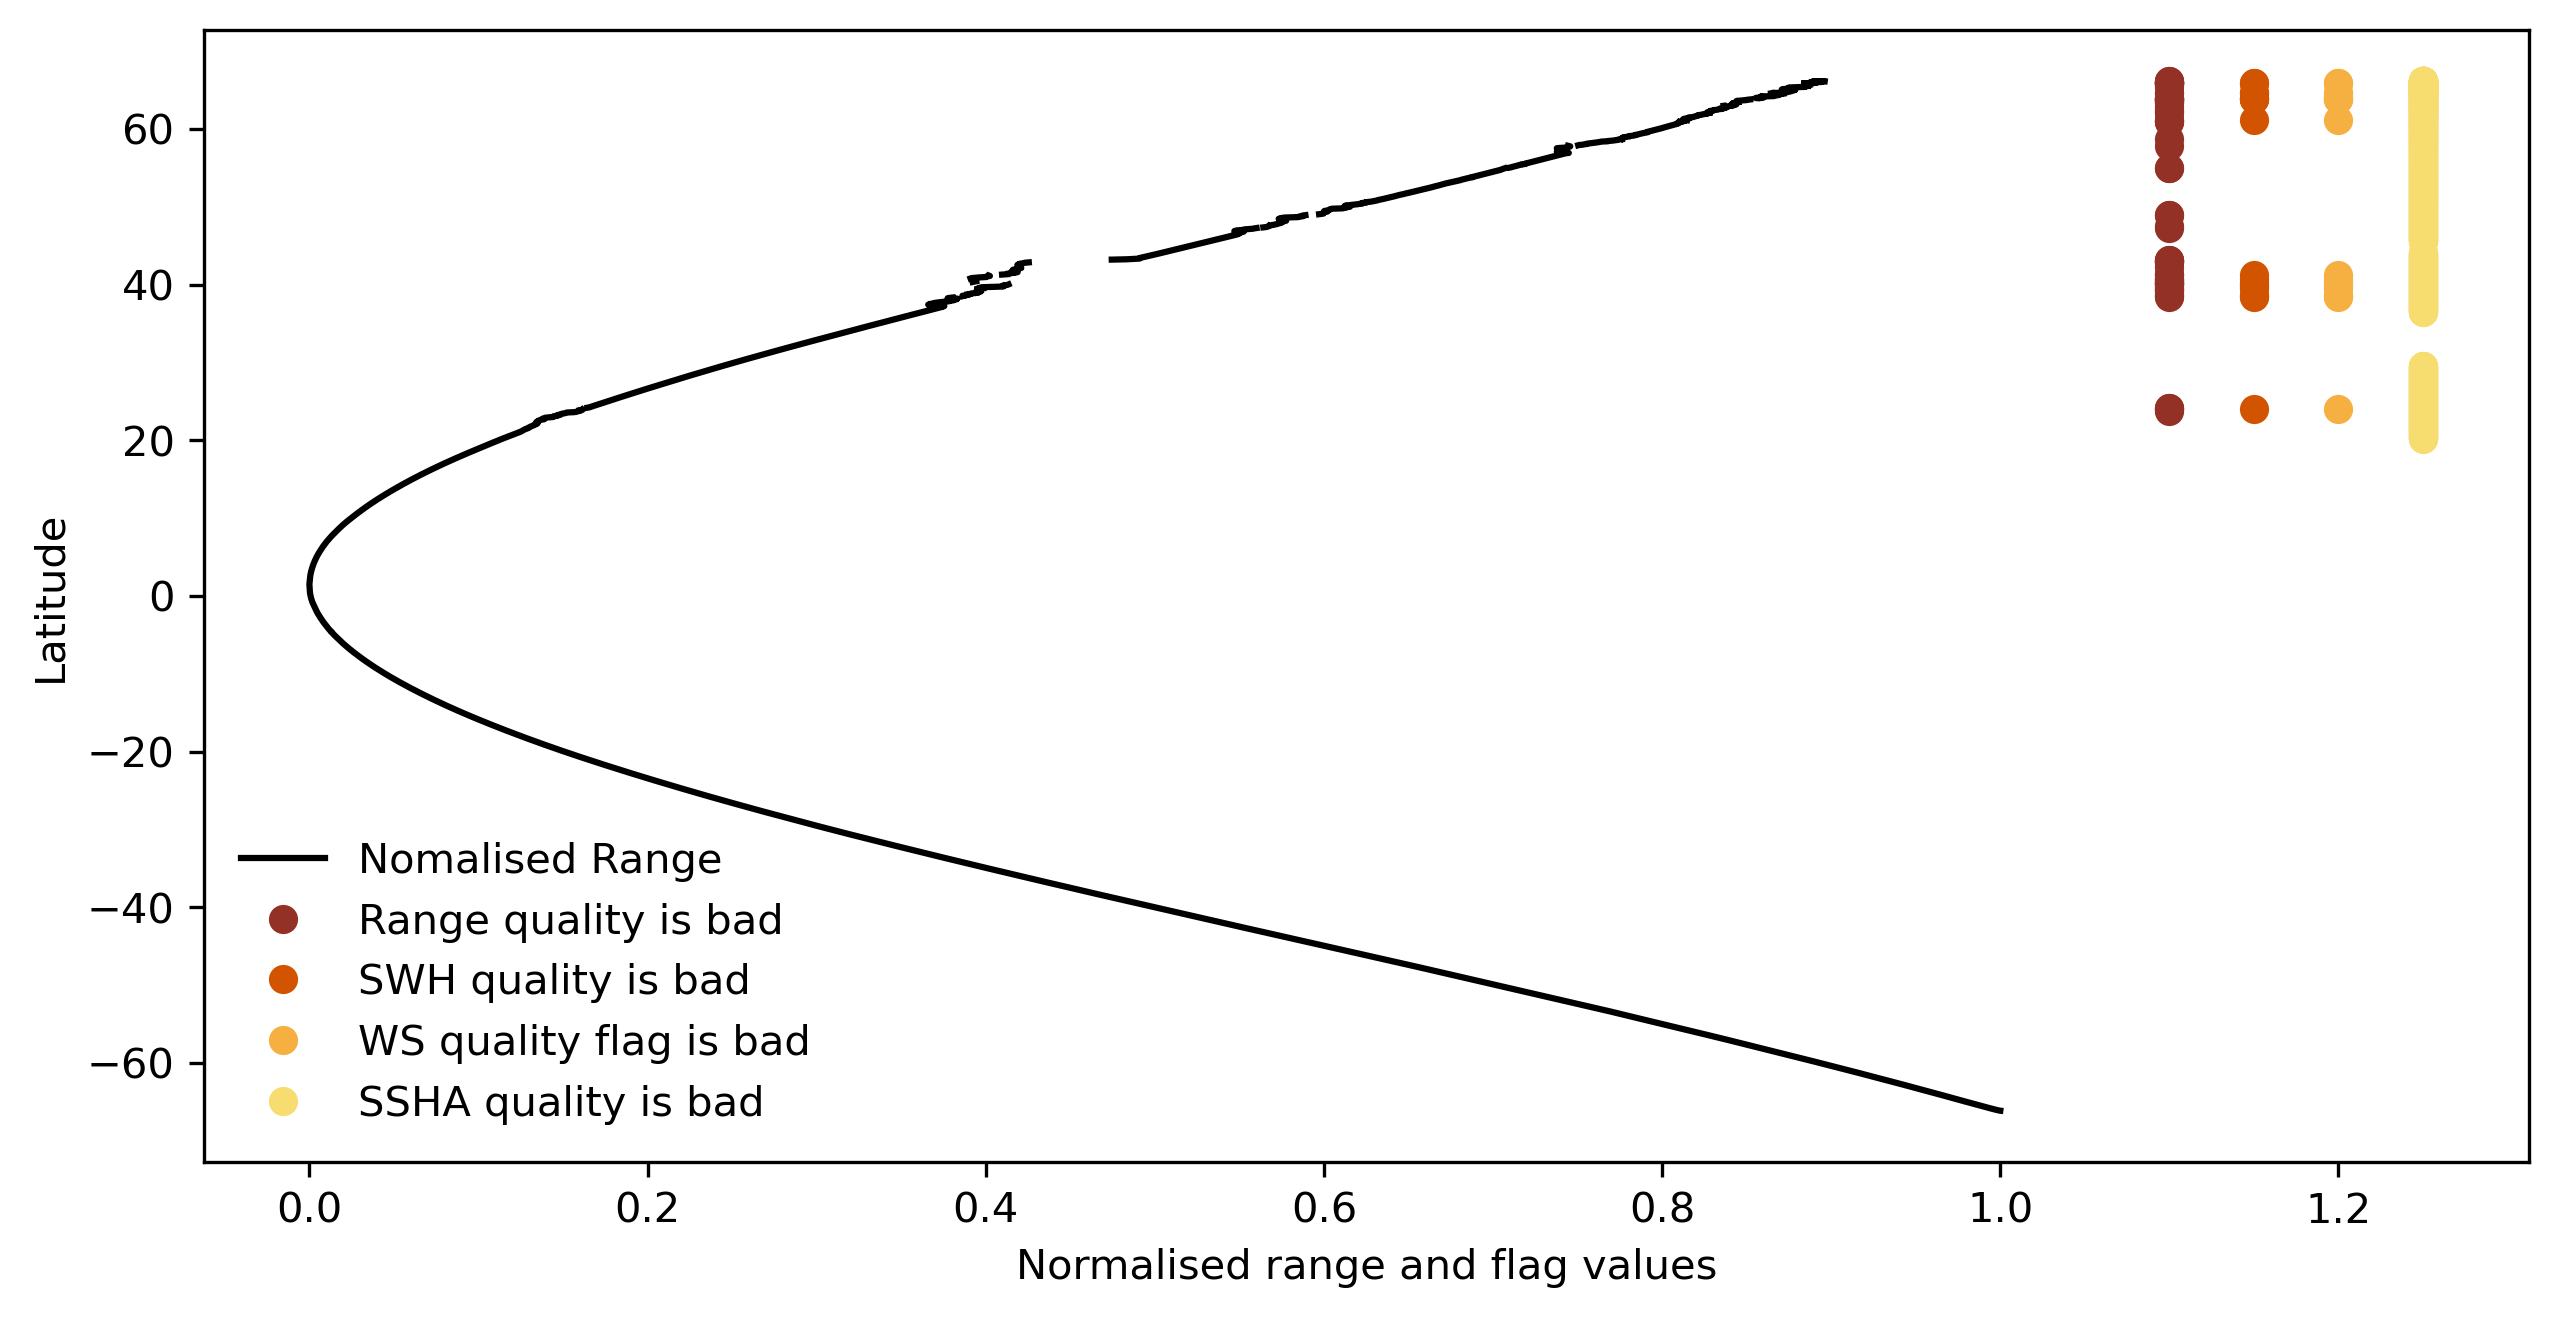

In [7]:
# plot the flags and normalised range
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
p1, = axs.plot(norm_range, ds_01.latitude, 'k', label='Nomalised Range')
p2, = axs.plot(flags_range, ds_01.latitude, '#943126', marker='o', linewidth=0.0, label='Range quality is bad')
p3, = axs.plot(flags_swh, ds_01.latitude, '#D35400', marker='o', linewidth=0.0, label='SWH quality is bad')
p4, = axs.plot(flags_ws, ds_01.latitude, '#F5B041', marker='o', linewidth=0.0, label='WS quality flag is bad')
p5, = axs.plot(flags_ssha, ds_01.latitude, '#F7DC6F', marker='o', linewidth=0.0, label='SSHA quality is bad')
plt.xlabel('Normalised range and flag values')
plt.ylabel('Latitude')

handles, labels = axs.get_legend_handles_labels()
plt.legend(handles, labels, loc='lower left', fontsize=10, frameon=False)
plt.show()

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_4_S6_coverage.ipynb"><< Determining Poseidon-4 coverage</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_S6_waveforms.ipynb">Poseidon-4 waveforms >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>